# Image classification
**Profect description:** Car model classification by image.
# Work plan
1. Pick Xception network learned on ImageNet dataset.
2. Learn NN and predict class.

In [1]:
!nvidia-smi

Wed Jan 13 10:07:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [3]:
import os
import shutil
import sys
import zipfile
from pathlib import Path

import albumentations as A
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
# from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor


print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Numpy:'.ljust(16), np.__version__)
print('Pandas:'.ljust(16), pd.__version__)
print('TensorFlow:'.ljust(16), tf.__version__)
print('Keras:'.ljust(16), tf.keras.__version__)

Python:          3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy:           1.17.5
Pandas:          1.1.5
TensorFlow:      2.3.1
Keras:           2.4.0


In [4]:
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/train.zip
/kaggle/input/sample-submission.csv
/kaggle/input/test.zip
/kaggle/input/train.csv
/kaggle/working/__notebook__.ipynb


In [5]:
# Save requirements
!pip freeze > requirements.txt

In [6]:
# G L O B A L   C O N S T A N T S
RANDOM_SEED          = 42    # Random seed
# np.random.seed(RANDOM_SEED)  

EPOCHS               = 7     # Epochs to learn
BATCH_SIZE           = 32    #64 # Batch size to learn
LR                   = 1e-4  # Learning rate
VALIDATION_SPLIT     = 0.15  # Fraction of images reserved for validation (strictly between 0 and 1)

CLASS_NUM            = 10    # Number of classes
IMG_SIZE             = 380   #224 # Image size for network input
IMG_CHANNELS         = 3     # Image channels (3 channels in RGB)
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [7]:
# Declare input data directory
DATA_PATH = '../input/'

# Create working directories
WORKING_PATH = '../working/car/'
os.makedirs(WORKING_PATH)
os.makedirs(WORKING_PATH + 'test/')

# Unzip files to working directory to see them
with zipfile.ZipFile(DATA_PATH + 'train.zip', 'r') as z:
    z.extractall(WORKING_PATH)
with zipfile.ZipFile(DATA_PATH + 'test.zip', 'r') as z:
    z.extractall(WORKING_PATH + 'test/')
print(os.listdir(WORKING_PATH))

# Move all train files into the same folder
# for class_num in range(10):
#     src_path = WORKING_PATH + 'train/' + str(class_num) + '/'
#     for each_file in Path(src_path).glob('*.*'): # grabs all files
#         trg_path = each_file.parent.parent # gets the parent of the folder 
#         each_file.rename(trg_path.joinpath(each_file.name)) # moves to parent folder.
#     Path(src_path).rmdir() # deletes empty folder
# print(len(os.listdir(WORKING_PATH + 'train/')))

['train', 'test']


# EDA

In [8]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

In [9]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

**Show general information of datasets**

In [10]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [11]:
sample_submission.head()

,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


In [12]:
train_df.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6675 entries, 0 to 6674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6675 non-null   object
 1   Category  6675 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.4+ KB


**View unique values**

In [13]:
train_df['Category'].value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

The distribution of classes is fairly uniform - that's good

**View images**

Image examples (random sample)


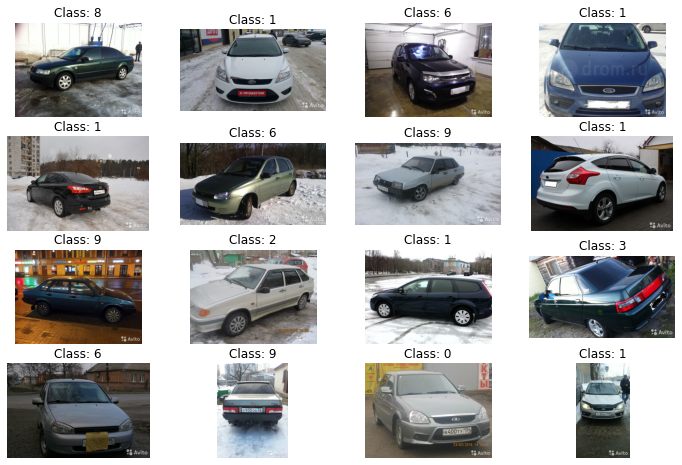

In [14]:
# Show image examples
print('Image examples (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=16)
random_image_id = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, image_id in enumerate(random_image_id):
    img = PIL.Image.open(WORKING_PATH + f'train/{random_image_cat[index]}/{image_id}')
    plt.subplot(4, 4, index + 1)
    plt.imshow(img)
    plt.title('Class: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Let's look at examples of pictures and their sizes in order to understand how to better process and compress them

(640, 480)

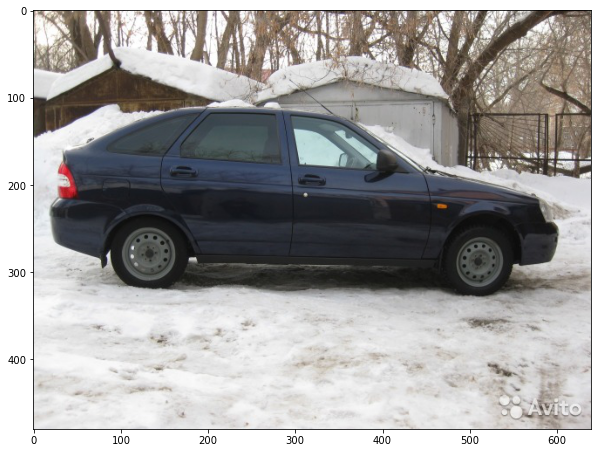

In [15]:
img = PIL.Image.open(WORKING_PATH + '/train/0/100380.jpg')
visualize(img)
img.size

# Data preparing
## Stratified splitting

In [16]:
# Split on train and validation parts
train_files, validation_files = train_test_split(
    train_df, test_size=VALIDATION_SPLIT,
    random_state=RANDOM_SEED, stratify=train_df['Category'],
)
train_files.shape, validation_files.shape

((13226, 2), (2335, 2))

In [17]:
train_files['Category'].value_counts()

1    1675
8    1500
6    1473
5    1386
0    1371
3    1299
2    1239
4    1190
9    1067
7    1026
Name: Category, dtype: int64

In [18]:
validation_files['Category'].value_counts()

1    296
8    265
6    260
5    245
0    242
3    229
2    219
4    210
9    188
7    181
Name: Category, dtype: int64

## Data augmentation

Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
Официальная документация: https://keras.io/preprocessing/image/

Рекомендация: Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

In [19]:
# # Configure augmentation
# transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50,
#                        rotate_limit=45, p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.3,
#                                contrast_limit=0.3, p=0.5),
# ])

# # Transform image
# pillow_image = PIL.Image.open(WORKING_PATH + '/train/0/100380.jpg')
# array_image_aug = transform(image=np.array(pillow_image))['image']
# pillow_image_aug = PIL.Image.fromarray(array_image_aug)
# visualize(pillow_image_aug)

# # Save image to disc
# pillow_image_aug.save(WORKING_PATH + 'zzz.jpg', 'JPEG')

In [20]:
# Initialize data generators for train and test
train_datagen = image.ImageDataGenerator(
#     rotation_range=5,
#     horizontal_flip=False,
    rescale=1. / 255,
    validation_split=VALIDATION_SPLIT,
)
test_datagen = image.ImageDataGenerator(rescale=1. / 255)

In [21]:
# Wrap training data to generator
train_generator = train_datagen.flow_from_directory(
    directory=WORKING_PATH + 'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    subset='training',
)

# Wrap validation data to generator
valid_generator = train_datagen.flow_from_directory(
    directory=WORKING_PATH + 'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    subset='validation',
)

# Wrap test data to generator
test_generator = test_datagen.flow_from_directory(
    directory=WORKING_PATH + 'test/',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=RANDOM_SEED,
)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 images belonging to 1 classes.


In [22]:
# transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.5),
# ])

# # Initialize data generators for train and test
# train_datagen = ImageDataAugmentor(
#     rescale=1. / 255,
#     augment=transform,
#     preprocess_input=None,
#     seed=RANDOM_SEED,
#     validation_split=VALIDATION_SPLIT,
# )
# test_datagen = ImageDataAugmentor(
#     rescale=1. / 255,
#     augment=None,
#     preprocess_input=None,
#     seed=RANDOM_SEED,
# )

# # Wrap training data to generator
# train_generator = train_datagen.flow_from_directory(
#     directory=WORKING_PATH + 'train/',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     subset='training',
# )

# # Wrap validation data to generator
# valid_generator = train_datagen.flow_from_directory(
#     directory=WORKING_PATH + 'train/',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     subset='validation',
# )

# # Wrap test data to generator
# test_generator = test_datagen.flow_from_directory(
#     directory=WORKING_PATH + 'test/',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode=None,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
# )

# train_generator.show_data() # Visualize a bunch of augmented data

# Model implementation
## Configure checkpoint list

In [23]:
# Configure checkpoint list
checkpoint_1 = ModelCheckpoint(filepath='model.hdf5',
                               monitor=['val_accuracy'],
                               verbose=1,
                               save_best_only=False,
                               mode='max')
checkpoint_2 = ModelCheckpoint(filepath='best_model.hdf5',
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')
callbacks_list = [checkpoint_1, checkpoint_2]

## Assemble the model

In [24]:
# Clear session
clear_session()

# Load pre-trained Xception net as a base model
base_model = Xception(include_top=False, input_shape=INPUT_SHAPE)

# Add a new "head"(pooling, fully-connected relu, dropout, fully-connected softmax)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(CLASS_NUM, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

83689472/83683744 [==============================] - 1s 0us/step


Рекомендация: Попробуйте и другие архитектуры сетей

## Compile the model

In [25]:
# Compile the model for training
model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View the model configuration
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 189, 189, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 189, 189, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 189, 189, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

Рекомендация: Попробуйте добавить Batch Normalization

Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/

Рекомендация 2. Используйте разные техники управления Learning Rate
https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
http://teleported.in/posts/cyclic-learning-rate/ (eng)

## Model learning

In [26]:
history = model.fit(
    x=train_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    validation_data=valid_generator, 
)

Epoch 1/7
414/414 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.8509
Epoch 00001: saving model to model.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.95706, saving model to best_model.hdf5
414/414 [==============================] - 501s 1s/step - loss: 0.4635 - accuracy: 0.8509 - val_loss: 0.1272 - val_accuracy: 0.9571
Epoch 2/7
414/414 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9759
Epoch 00002: saving model to model.hdf5

Epoch 00002: val_accuracy did not improve from 0.95706
414/414 [==============================] - 499s 1s/step - loss: 0.0735 - accuracy: 0.9759 - val_loss: 0.1627 - val_accuracy: 0.9399
Epoch 3/7
414/414 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9897
Epoch 00003: saving model to model.hdf5

Epoch 00003: val_accuracy did not improve from 0.95706
414/414 [==============================] - 498s 1s/step - loss: 0.0323 - accuracy: 0.9897 - val_loss: 0.1695 - val_accuracy: 0.95

Рекомендация: попробуйте применить transfer learning с fine-tuning

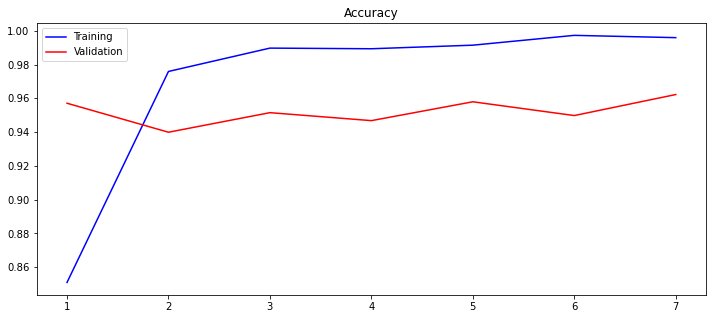

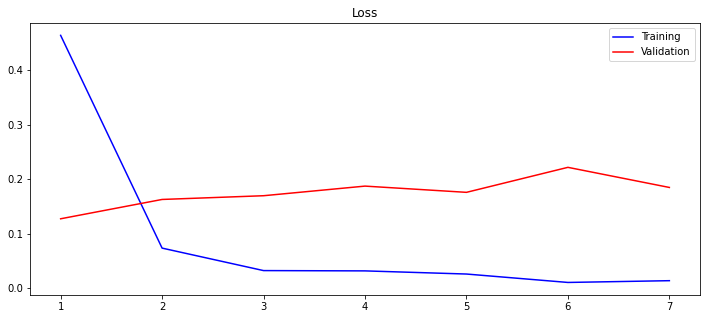

In [27]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.plot(epochs, accuracy, 'b', label='Training')
plt.plot(epochs, val_accuracy, 'r', label='Validation')
plt.title('Accuracy')
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validation')
plt.title('Loss')
plt.legend();

## Model testing

In [28]:
# Load model with the best result
model.load_weights('best_model.hdf5')

# Compute score
scores = model.evaluate(valid_generator)
print("Validation accuracy: %.2f %%" % (scores[1]*100))

73/73 [==============================] - 23s 314ms/step - loss: 0.1847 - accuracy: 0.9622
Validation accuracy: 96.22 %


# Submission
## Learn on 100 % of data

In [29]:
# Initialize data generators for train and test
train_datagen = image.ImageDataGenerator(
#     rotation_range=5,
#     horizontal_flip=False,
    rescale=1. / 255,
)

# Wrap training data to generator
train_generator = train_datagen.flow_from_directory(
    directory=WORKING_PATH + 'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
)

# Configure checkpoint list
checkpoint = ModelCheckpoint(filepath='best_model_all_data.hdf5',
                               monitor='accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

# Clear session
clear_session()

# Load pre-trained Xception net as a base model
base_model = Xception(include_top=False, input_shape=INPUT_SHAPE)

# Add a new "head"(pooling, fully-connected relu, dropout, fully-connected softmax)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(CLASS_NUM, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compile the model for training
model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learn
model.fit(
    x=train_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint],
)

# Load model with the best result
model.load_weights('best_model_all_data.hdf5')

# Compute score
scores = model.evaluate(train_generator)
print()
print("Train accuracy: %.2f %%" % (scores[1]*100))

Found 15561 images belonging to 10 classes.
Epoch 1/7
487/487 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.8462
Epoch 00001: accuracy improved from -inf to 0.84622, saving model to best_model_all_data.hdf5
487/487 [==============================] - 558s 1s/step - loss: 0.4545 - accuracy: 0.8462
Epoch 2/7
487/487 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9740
Epoch 00002: accuracy improved from 0.84622 to 0.97404, saving model to best_model_all_data.hdf5
487/487 [==============================] - 558s 1s/step - loss: 0.0791 - accuracy: 0.9740
Epoch 3/7
487/487 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9870
Epoch 00003: accuracy improved from 0.97404 to 0.98695, saving model to best_model_all_data.hdf5
487/487 [==============================] - 558s 1s/step - loss: 0.0393 - accuracy: 0.9870
Epoch 4/7
487/487 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9934
Epoch 00004: accur

## Predict

In [30]:
# Predict probabilities for all classes
predictions = model.predict(test_generator)
print(predictions.shape)

# Choose indices for classes with maximum probability
predictions = np.argmax(predictions, axis=-1)
print(predictions.shape)

# Swap labels and indices of classes
label_map = train_generator.class_indices
label_map = dict((index, label) for label, index in label_map.items())

# Replace indices with classes
predictions = [label_map[k] for k in predictions]
print(len(predictions))

(6675, 10)
(6675,)
6675


## Save to submission file

In [31]:
# Save to file
submission = pd.DataFrame({'Id': test_generator.filenames, 'Category': predictions})
submission['Id'] = submission['Id'].str.replace('test_upload/', '')
submission.to_csv('submission.csv', index=False)
submission

,Id,Category
0,293307.jpg,3
1,293359.jpg,3
2,293370.jpg,3
3,293435.jpg,3
4,293520.jpg,3
...,...,...
6670,99968.jpg,8
6671,99972.jpg,3
6672,99977.jpg,2
6673,99979.jpg,0


Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [32]:
# Clean WORKING_PATH
shutil.rmtree(WORKING_PATH)

# Что можно сделать, чтобы улучшить результат:
* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )